In [36]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG16
from keras import layers
from keras.models import Model
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from keras.utils import plot_model
%matplotlib inline

In [2]:
#load the data we saved fron pre_data notebook
dtr,dval,dte = pickle.load(open('gender_data.pkl','rb'))

### since the size of the training data is too large to be hold in memory one time, we save batches of training data of size 32 in files

In [3]:
X,Y = [],[] 
# number of current training files till now
cnt = 0 
# iterate over all training data
for i,r in dtr.iterrows(): 
    # data is in path folder
    path = 'aligned/' + r['path'] 
    # load image with size (224,224,3)
    img = image.load_img(path, target_size=(224,224)) 
    img = image.img_to_array(img)
    # images need to be in shape (#sampels,224,224,3), where here #sampler = 1
    img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    # preprocess image with preprocess_input provided by keras
    img = preprocess_input(img)
    # save current image
    X.append(img[0])
    # create label for current image
    Y.append(int(r['gender'] == 'm'))
    # if now we have 32 training data
    if len(X)%32 == 0:
        # increase number of training files
        cnt += 1
        if cnt % 50 == 0:
            print(cnt)
        # save current training data
        pickle.dump([np.array(X),np.array(Y)],open('bench_train_files/train' + str(cnt) + '.pkl','wb'))
        X,Y = [],[]

50
100
150


### same as above but in the validation data

In [4]:
X,Y = [],[]
cnt = 0
for i,r in dval.iterrows():
    path = 'aligned/' + r['path']
    img = image.load_img(path, target_size=(224,224))
    img = image.img_to_array(img)
    img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    img = preprocess_input(img)
    X.append(img[0])
    Y.append(int(r['gender'] == 'm'))
    if len(X)%32 == 0:
        cnt += 1
        if cnt % 50 == 0:
            print(cnt)
        pickle.dump([np.array(X),np.array(Y)],open('bench_val_files/train' + str(cnt) + '.pkl','wb'))
        X,Y = [],[]

50


### create a simple network with one Conv layer as a benchmark model

In [28]:
# input for the network 
in1 = layers.Input(shape=(224,224,3))

# decrease dimensions of the image
X = layers.AveragePooling2D(5)(in1)

# one Conv layer for learning
X = layers.Conv2D(64,5,padding='valid',activation='relu')(X)

X = layers.GlobalAveragePooling2D()(X)

# add a fully connected layer
X = layers.Dense(32,activation='relu')(X)
# add some dropout to not over-fit
X = layers.Dropout(0.5)(X)

# our final layer
X = layers.Dense(1,activation='sigmoid')(X)
model = Model(inputs=in1,outputs=X)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 44, 44, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 40, 64)        4864      
_________________________________________________________________
global_average_pooling2d_8 ( (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total para

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [31]:
def gen():
    # generate training files for training the model
    # iterate over all 187 files we created
    i = 0
    while True:
        i = i + 1
        x,y = pickle.load(open('bench_train_files/train' + str(i) + '.pkl','rb'))
        yield x,y
        if i == 187:
            i = 0

In [32]:
def gen2():
    # generate validation files for training the model
    # iterate over all 62 files we created
    i = 0
    while True:
        i = i + 1
        x,y = pickle.load(open('bench_val_files/train' + str(i) + '.pkl','rb'))
        yield x,y
        if i == 62:
            i = 0

In [ ]:
# train the model on files with 16 epochs
# this took much time since i'm working on CPU
hist = model.fit_generator(generator=gen(),epochs=16,steps_per_epoch=187,validation_data=gen2(),validation_steps=62,verbose=2)

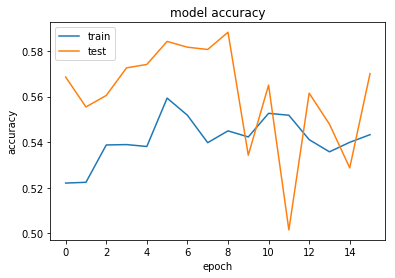

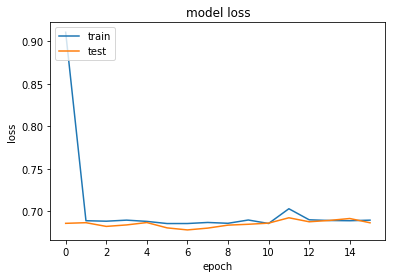

In [35]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()